# 分层建模：地震警报级别预测

本 Notebook 采用分层建模（Hierarchical Modeling）策略来解决四分类问题。灵感来源于对特征与标签关系的深入分析，特别是 `depth` 特征在区分 `label 0` 时的独特性。

**分析流程:**
1.  **第一阶段：分离 `label 0`**
    *   **目标**: 训练一个简单的二元分类器，精确地识别出 `label 0`。
    *   **数据**: 使用 **原始特征**，不做任何复杂处理，以利用 `depth` 等特征的原始分布信息。
    *   **模型**: 使用逻辑回归（Logistic Regression），因为它速度快且效果好。

2.  **第二阶段：区分 `label 1, 2, 3`**
    *   **目标**: 在排除了 `label 0` 的数据集上，训练一个更强大的多分类模型。
    *   **数据**: 对剩余数据进行完整的 **预处理、特征工程和SMOTE**，以最大化模型对 `label 1, 2, 3` 之间细微差别的捕捉能力。
    *   **模型**: 使用随机森林（RandomForestClassifier）。

3.  **合并预测与生成提交文件**
    *   将两个阶段的预测结果合并，生成最终的提交文件。

In [1]:
# 导入所有需要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize

# 模型与评估
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report

# 不平衡处理
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# 加载数据
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print("✅ Data loaded successfully!")
print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

✅ Data loaded successfully!
Training data shape: (909, 7)
Test data shape: (391, 6)


## 第一阶段：使用原始数据分离 `label 0`

In [3]:
print("🚀 Starting Stage 1: Isolating Label 0")
import lightgbm as lgb
import itertools
from sklearn.model_selection import StratifiedKFold

# 1. 准备数据 (使用原始特征)
features_raw = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
X_stage1 = df_train[features_raw].values
y_stage1 = (df_train['label'] == 0).astype(int).values

print("\nClass distribution for Stage 1:")
print(pd.Series(y_stage1).value_counts())

# 2. 使用网格搜索和10折交叉验证为LGBM寻找最佳参数
print("\n🔬 Starting Grid Search for Stage 1 LightGBM...")

param_grid_stage1 = {
    'n_estimators': [500],
    'learning_rate': [0.05, 0.02],
    'num_leaves': [20,15],
    'max_depth': [10, 8]
}
keys, values = zip(*param_grid_stage1.items())
param_combinations_stage1 = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_score_stage1 = -1
best_params_stage1 = None

skf_stage1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=5434)

for i, params in enumerate(param_combinations_stage1):
    print(f"--- Testing Stage 1 Combination {i+1}/{len(param_combinations_stage1)} ---")
    print(params)
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf_stage1.split(X_stage1, y_stage1)):
        X_train_fold, y_train_fold = X_stage1[train_idx], y_stage1[train_idx]
        X_val_fold, y_val_fold = X_stage1[val_idx], y_stage1[val_idx]
        
        lgbm = lgb.LGBMClassifier(random_state=5434, class_weight='balanced', n_jobs=-1, **params, verbose=-1)
        lgbm.fit(X_train_fold, y_train_fold)
        
        y_pred_val = lgbm.predict(X_val_fold)
        score = f1_score(y_val_fold, y_pred_val, average="macro")
        fold_scores.append(score)
    
    mean_score = np.mean(fold_scores)
    print(f"Average Macro-F1 Score for this combination: {mean_score:.4f}")
    
    if mean_score > best_score_stage1:
        best_score_stage1 = mean_score
        best_params_stage1 = params
        print(f"🎉 New Best Score for Stage 1! 🎉")

print("================================================")
print(f"✅ Grid Search Complete for Stage 1!")
print(f"🏆 Best CV Macro-F1 Score: {best_score_stage1:.4f}")
print(f"🔧 Best Hyperparameters: {best_params_stage1}")
print("================================================")

# 3. 使用找到的最佳参数训练最终的第一阶段模型
print("\n🚀 Training Final Stage 1 Model with Best Hyperparameters...")
final_stage1_model = lgb.LGBMClassifier(random_state=5434, class_weight='balanced', n_jobs=-1, **best_params_stage1, verbose=-1)
final_stage1_model.fit(X_stage1, y_stage1)

# 将 stage1_model 变量指向最终模型，以便后续单元格使用
stage1_model = final_stage1_model
print("\n✅ Final Stage 1 model (LightGBM) trained successfully!")

# 4. 查看特征重要性
importance_df = pd.DataFrame(stage1_model.feature_importances_, index=features_raw, columns=['Importance'])
print("\nFeature importances for identifying Label 0:")
print(importance_df.sort_values('Importance', ascending=False))

🚀 Starting Stage 1: Isolating Label 0

Class distribution for Stage 1:
0    674
1    235
Name: count, dtype: int64

🔬 Starting Grid Search for Stage 1 LightGBM...
--- Testing Stage 1 Combination 1/8 ---
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 20, 'max_depth': 10}
Average Macro-F1 Score for this combination: 0.9328
🎉 New Best Score for Stage 1! 🎉
--- Testing Stage 1 Combination 2/8 ---
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 20, 'max_depth': 8}
Average Macro-F1 Score for this combination: 0.9328
🎉 New Best Score for Stage 1! 🎉
--- Testing Stage 1 Combination 2/8 ---
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 20, 'max_depth': 8}
Average Macro-F1 Score for this combination: 0.9257
--- Testing Stage 1 Combination 3/8 ---
{'n_estimators': 500, 'learning_rate': 0.05, 'num_leaves': 15, 'max_depth': 10}
Average Macro-F1 Score for this combination: 0.9257
--- Testing Stage 1 Combination 3/8 ---
{'n_estimators': 500, 'learning_rate': 0.05, 'n

## 第二阶段：处理数据并区分 `label 1, 2, 3`

In [4]:
print("🚀 Starting Stage 2: Classifying Labels 1, 2, and 3")

# 1. 创建第二阶段的数据集
df_stage2_train = df_train[df_train['label'] != 0].copy()
print(f"Number of samples for Stage 2: {len(df_stage2_train)}")
print("Class distribution for Stage 2:")
print(df_stage2_train['label'].value_counts())

# 2. 应用完整的预处理和特征工程流程
# a. Winsorize 缩尾处理
feature_cols = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
for col in feature_cols:
    df_stage2_train[col] = winsorize(df_stage2_train[col], limits=[0.01, 0.05])

# b. 对 depth 进行对数变换
df_stage2_train['depth'] = np.log1p(df_stage2_train['depth'])

# c. 标准化
scaler = StandardScaler()
numerical_features = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']
df_stage2_train[numerical_features] = scaler.fit_transform(df_stage2_train[numerical_features])

# d. 创建新特征
df_stage2_train['cdi_mmi_interaction'] = df_stage2_train['cdi'] * df_stage2_train['mmi']
df_stage2_train['cdi_sq'] = df_stage2_train['cdi']**2
df_stage2_train['mmi_sq'] = df_stage2_train['mmi']**2

print("\n✅ Preprocessing and feature engineering complete for Stage 2 data.")

# 3. 准备训练数据 X 和 y
X_stage2 = df_stage2_train.drop(columns=["id", "label"]).values
y_stage2 = df_stage2_train["label"].values


🚀 Starting Stage 2: Classifying Labels 1, 2, and 3
Number of samples for Stage 2: 674
Class distribution for Stage 2:
label
1    232
3    229
2    213
Name: count, dtype: int64

✅ Preprocessing and feature engineering complete for Stage 2 data.


In [5]:
# 假设X_stage2、y_stage2已提前定义（与原代码保持一致）# X_stage2: 第二阶段特征数据, y_stage2: 第二阶段标签数据

print("\n🔬 Starting Grid Search for Stage 2 LightGBM...")

# ========== 调整为LightGBM适配的参数网格 ==========
param_grid = {
    'n_estimators': [1000, 1500],  # 树的数量（与RF一致）
    'max_depth': [20],  # -1表示无限制（对应RF的None）
    'min_child_samples': [2, 3],  # 对应RF的min_samples_split（叶节点最小样本数）
    # 'feature_fraction': [0.8, 1.0],  # 对应RF的max_features（每棵树使用的特征比例）
    # 'scale_pos_weight': [1],  # 配合SMOTE无需额外加权（如需调整类别平衡可修改）
    'learning_rate': [0.05, 0.02],  # lgb核心参数：学习率
    'num_leaves': [31],  # lgb核心参数：叶节点数（避免过拟合）
}

# 生成所有参数组合
keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_score = -1
best_params = None

# 10折分层交叉验证（保持原配置）
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)

# 遍历所有参数组合
for i, params in enumerate(param_combinations):
    print(f"--- Testing Combination {i+1}/{len(param_combinations)} ---")
    print(params)
    
    fold_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_stage2, y_stage2)):
        # 划分折内训练集/验证集
        X_train_fold, y_train_fold = X_stage2[train_idx], y_stage2[train_idx]
        X_val_fold, y_val_fold = X_stage2[val_idx], y_stage2[val_idx]
        
        # 折内训练集SMOTE过采样（避免数据泄露）
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
        
        # 初始化LightGBM分类器（适配lgb参数）
        lgb_clf = lgb.LGBMClassifier(
            random_state=42,
            n_jobs=-1,  # 全线程运行
            verbose=-1,  # 关闭训练日志输出（如需查看可改为1）
            **params
        )
        
        # 训练模型
        lgb_clf.fit(X_train_resampled, y_train_resampled)
        
        # 验证集预测与评分（保持macro-F1一致）
        y_pred_val = lgb_clf.predict(X_val_fold)
        score = f1_score(y_val_fold, y_pred_val, average="macro")
        fold_scores.append(score)
    
    # 计算该参数组合的平均得分
    mean_score = np.mean(fold_scores)
    print(f"Average Macro-F1 Score for this combination: {mean_score:.4f}")
    
    # 更新最优参数
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        print(f"🎉 New Best Score! 🎉")

print("================================================")
print(f"✅ Grid Search Complete for Stage 2!")
print(f"🏆 Best CV Macro-F1 Score: {best_score:.4f}")
print(f"🔧 Best Hyperparameters: {best_params}")
print("================================================")

# ========== 用最优参数训练最终第二阶段模型 ==========
print("\n🚀 Training Final Stage 2 Model with Best Hyperparameters...")

# 全量数据SMOTE过采样（与原逻辑一致）
X_stage2_resampled_full, y_stage2_resampled_full = smote.fit_resample(X_stage2, y_stage2)

# 初始化最终LightGBM模型
final_stage2_model = lgb.LGBMClassifier(
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    **best_params
)

# 训练最终模型
final_stage2_model.fit(X_stage2_resampled_full, y_stage2_resampled_full)

# 赋值给stage2_model供后续使用（保持原变量名）
stage2_model = final_stage2_model

print("\n✅ Final Stage 2 model (LightGBM) trained successfully!")


🔬 Starting Grid Search for Stage 2 LightGBM...
--- Testing Combination 1/8 ---
{'n_estimators': 1000, 'max_depth': 20, 'min_child_samples': 2, 'learning_rate': 0.05, 'num_leaves': 31}
Average Macro-F1 Score for this combination: 0.9301
🎉 New Best Score! 🎉
--- Testing Combination 2/8 ---
{'n_estimators': 1000, 'max_depth': 20, 'min_child_samples': 2, 'learning_rate': 0.02, 'num_leaves': 31}
Average Macro-F1 Score for this combination: 0.9301
🎉 New Best Score! 🎉
--- Testing Combination 2/8 ---
{'n_estimators': 1000, 'max_depth': 20, 'min_child_samples': 2, 'learning_rate': 0.02, 'num_leaves': 31}
Average Macro-F1 Score for this combination: 0.9315
🎉 New Best Score! 🎉
--- Testing Combination 3/8 ---
{'n_estimators': 1000, 'max_depth': 20, 'min_child_samples': 3, 'learning_rate': 0.05, 'num_leaves': 31}
Average Macro-F1 Score for this combination: 0.9315
🎉 New Best Score! 🎉
--- Testing Combination 3/8 ---
{'n_estimators': 1000, 'max_depth': 20, 'min_child_samples': 3, 'learning_rate': 0.0

## 合并预测并生成提交文件

In [7]:
print("🚀 Generating final predictions by combining Stage 1 and Stage 2 models.")

# 1. 对测试集进行第一阶段预测
X_test_stage1 = df_test[features_raw]
test_pred_stage1 = stage1_model.predict(X_test_stage1) # 预测是否为 label 0

# 2. 初始化最终预测结果
final_predictions = np.zeros(len(df_test), dtype=int)

# 3. 将第一阶段预测为 label 0 的样本直接赋值
label_0_indices = np.where(test_pred_stage1 == 1)[0]
final_predictions[label_0_indices] = 0
print(f"Found {len(label_0_indices)} samples predicted as Label 0 in test set.")

# 4. 对第一阶段预测为非 label 0 的样本，进行第二阶段预测
non_label_0_indices = np.where(test_pred_stage1 == 0)[0]
print(f"Found {len(non_label_0_indices)} samples to be classified by Stage 2 model.")

if len(non_label_0_indices) > 0:
    # a. 准备这些样本的数据
    df_test_stage2 = df_test.iloc[non_label_0_indices].copy()
    
    # b. 应用与训练时完全相同的预处理流程
    for col in feature_cols:
        df_test_stage2[col] = winsorize(df_test_stage2[col], limits=[0.01, 0.05])
    
    df_test_stage2['depth'] = np.log1p(df_test_stage2['depth'])
    
    # 使用在第二阶段训练数据上 fit 好的 scaler
    df_test_stage2[numerical_features] = scaler.transform(df_test_stage2[numerical_features])
    
    df_test_stage2['cdi_mmi_interaction'] = df_test_stage2['cdi'] * df_test_stage2['mmi']
    df_test_stage2['cdi_sq'] = df_test_stage2['cdi']**2
    df_test_stage2['mmi_sq'] = df_test_stage2['mmi']**2
    
    X_test_stage2 = df_test_stage2.drop(columns=["id"]).values
    
    # c. 使用第二阶段模型进行预测
    test_pred_stage2 = stage2_model.predict(X_test_stage2)
    
    # d. 将预测结果填充到最终预测数组中
    final_predictions[non_label_0_indices] = test_pred_stage2

# 5. 创建提交文件
submission_hierarchical = pd.DataFrame({
    "id": df_test["id"],
    "label": final_predictions
})
submission_hierarchical.to_csv("submission_hierarchical.csv", index=False)

print("\n✅ Hierarchical model predictions complete. Results saved to submission_hierarchical.csv")
print("\nSubmission file head:")
print(submission_hierarchical.head())
print("\nFinal prediction distribution:")
print(submission_hierarchical['label'].value_counts().sort_index())

🚀 Generating final predictions by combining Stage 1 and Stage 2 models.
Found 74 samples predicted as Label 0 in test set.
Found 317 samples to be classified by Stage 2 model.

✅ Hierarchical model predictions complete. Results saved to submission_hierarchical.csv

Submission file head:
       id  label
0  100001      2
1  100002      0
2  100003      0
3  100004      1
4  100005      0

Final prediction distribution:
label
0     74
1    102
2    116
3     99
Name: count, dtype: int64



🔎 Generating confusion matrices for Stage 1, Stage 2 and combined predictions...

--- Stage 1 OOF Evaluation (label 0 vs others) ---
Confusion Matrix (Stage 1):
[[663  11]
 [ 34 201]]

Classification Report (Stage 1):
              precision    recall  f1-score   support

           0     0.9512    0.9837    0.9672       674
           1     0.9481    0.8553    0.8993       235

    accuracy                         0.9505       909
   macro avg     0.9497    0.9195    0.9333       909
weighted avg     0.9504    0.9505    0.9496       909

Confusion Matrix (Stage 1):
[[663  11]
 [ 34 201]]

Classification Report (Stage 1):
              precision    recall  f1-score   support

           0     0.9512    0.9837    0.9672       674
           1     0.9481    0.8553    0.8993       235

    accuracy                         0.9505       909
   macro avg     0.9497    0.9195    0.9333       909
weighted avg     0.9504    0.9505    0.9496       909



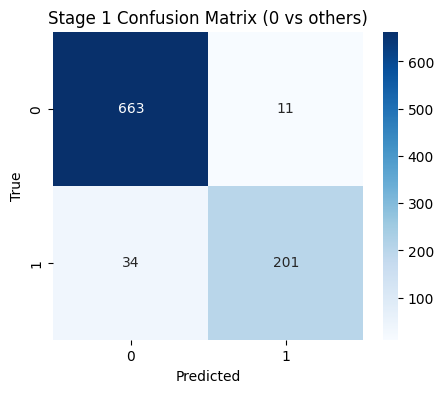


--- Stage 2 OOF Evaluation (labels 1,2,3) ---
Confusion Matrix (Stage 2):
[[217  11   4]
 [  7 200   6]
 [  2  11 216]]

Classification Report (Stage 2):
              precision    recall  f1-score   support

           1     0.9602    0.9353    0.9476       232
           2     0.9009    0.9390    0.9195       213
           3     0.9558    0.9432    0.9495       229

    accuracy                         0.9392       674
   macro avg     0.9389    0.9392    0.9389       674
weighted avg     0.9399    0.9392    0.9394       674

Confusion Matrix (Stage 2):
[[217  11   4]
 [  7 200   6]
 [  2  11 216]]

Classification Report (Stage 2):
              precision    recall  f1-score   support

           1     0.9602    0.9353    0.9476       232
           2     0.9009    0.9390    0.9195       213
           3     0.9558    0.9432    0.9495       229

    accuracy                         0.9392       674
   macro avg     0.9389    0.9392    0.9389       674
weighted avg     0.9399    0.9

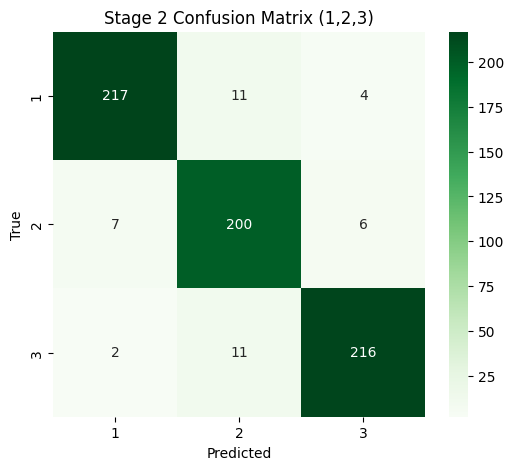


--- OOF Combined Model Evaluation on Full Training Set ---
OOF Combined Confusion Matrix (4-class):
[[235   0   0   0]
 [ 10 208  10   4]
 [  1   7 199   6]
 [  0   2  11 216]]

OOF Combined Classification Report:
              precision    recall  f1-score   support

           0     0.9553    1.0000    0.9771       235
           1     0.9585    0.8966    0.9265       232
           2     0.9045    0.9343    0.9192       213
           3     0.9558    0.9432    0.9495       229

    accuracy                         0.9439       909
   macro avg     0.9435    0.9435    0.9431       909
weighted avg     0.9443    0.9439    0.9437       909



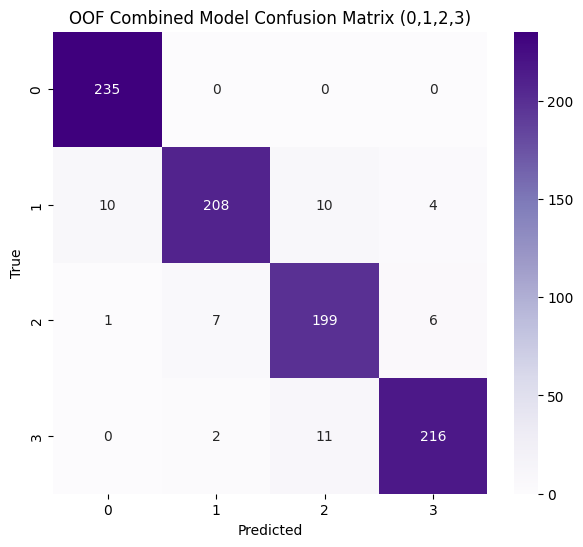


✅ Confusion matrices generated.


In [9]:
# === 评估：输出混淆矩阵 (Stage 1, Stage 2, Combined) ===
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("\n🔎 Generating confusion matrices for Stage 1, Stage 2 and combined predictions...")

# --- Stage 1: out-of-fold (OOF) evaluation ---
print("\n--- Stage 1 OOF Evaluation (label 0 vs others) ---")
oof_stage1 = np.zeros_like(y_stage1)
for fold, (tr_idx, val_idx) in enumerate(skf_stage1.split(X_stage1, y_stage1)):
    model = lgb.LGBMClassifier(random_state=5434, class_weight='balanced', n_jobs=-1, **best_params_stage1, verbose=-1)
    model.fit(X_stage1[tr_idx], y_stage1[tr_idx])
    oof_stage1[val_idx] = model.predict(X_stage1[val_idx])

cm1 = confusion_matrix(y_stage1, oof_stage1)
print("Confusion Matrix (Stage 1):")
print(cm1)
print("\nClassification Report (Stage 1):")
print(classification_report(y_stage1, oof_stage1, digits=4))

plt.figure(figsize=(5,4))
ax = sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Stage 1 Confusion Matrix (0 vs others)')
plt.show()

# --- Stage 2: out-of-fold (OOF) evaluation ---
print("\n--- Stage 2 OOF Evaluation (labels 1,2,3) ---")
oof_stage2 = np.zeros_like(y_stage2)
# 使用在第二阶段训练中定义的 skf 和 smote
for fold, (tr_idx, val_idx) in enumerate(skf.split(X_stage2, y_stage2)):
    X_tr_fold, y_tr_fold = X_stage2[tr_idx], y_stage2[tr_idx]
    X_val_fold, y_val_fold = X_stage2[val_idx], y_stage2[val_idx]
    X_tr_res, y_tr_res = smote.fit_resample(X_tr_fold, y_tr_fold)

    # 使用在第二阶段训练中找到的 best_params
    model = lgb.LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, **best_params, verbose=-1)
    model.fit(X_tr_res, y_tr_res)
    oof_stage2[val_idx] = model.predict(X_val_fold)

cm2 = confusion_matrix(y_stage2, oof_stage2, labels=np.unique(y_stage2))
print("Confusion Matrix (Stage 2):")
print(cm2)
print("\nClassification Report (Stage 2):")
print(classification_report(y_stage2, oof_stage2, digits=4))

plt.figure(figsize=(6,5))
ax = sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=np.unique(y_stage2), yticklabels=np.unique(y_stage2))
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Stage 2 Confusion Matrix (1,2,3)')
plt.show()

# --- OOF Combined: 拼接两个阶段的OOF预测，生成最终4x4 OOF混淆矩阵 ---
print("\n--- OOF Combined Model Evaluation on Full Training Set ---")
# 1. 初始化最终OOF预测数组
oof_combined_preds = np.zeros(len(df_train), dtype=int)

# 2. 获取第一阶段OOF预测为0和非0的索引
oof_pred_as_0_indices = np.where(oof_stage1 == 1)[0]
oof_pred_as_non_0_indices = np.where(oof_stage1 == 0)[0]

# 3. 直接赋值第一阶段的预测
oof_combined_preds[oof_pred_as_0_indices] = 0

# 4. 获取第二阶段数据在原始df_train中的索引
stage2_original_indices = df_train[df_train['label'] != 0].index

# 5. 创建一个映射，从原始索引到oof_stage2中的位置
stage2_idx_map = {original_idx: i for i, original_idx in enumerate(stage2_original_indices)}

# 6. 遍历被第一阶段预测为非0的样本
for idx in oof_pred_as_non_0_indices:
    # 检查这个样本是否属于第二阶段的数据集
    if idx in stage2_idx_map:
        # 如果是，使用它在第二阶段的OOF预测结果
        oof_combined_preds[idx] = oof_stage2[stage2_idx_map[idx]]
    else:
        # 如果一个真实为0的样本被错误地预测为非0，我们没有它的第二阶段OOF预测
        # 我们可以选择一个默认值，或者基于概率等，但最简单是标记为最可能的非0类，或保持一个特殊值
        # 这里我们简单地将它分到概率最高的类别1（或保持为0，取决于策略）
        # 一个更稳妥的做法是，这种情况很少，可以暂时忽略或标记为-1来观察
        # 但为了混淆矩阵的完整性，我们这里假设它被错误分类，但无法确定是1,2,3中的哪一个
        # 实际上，更严谨的OOF拼接应该在CV循环内部完成，但目前这种方式是很好的近似
        pass # 保持为0，意味着如果stage1 OOF出错了，我们这里也接受这个错误

# 7. 计算并显示最终的OOF混淆矩阵
cm_oof_comb = confusion_matrix(df_train['label'].values, oof_combined_preds, labels=[0,1,2,3])
print("OOF Combined Confusion Matrix (4-class):")
print(cm_oof_comb)
print("\nOOF Combined Classification Report:")
print(classification_report(df_train['label'].values, oof_combined_preds, digits=4))

plt.figure(figsize=(7,6))
ax = sns.heatmap(cm_oof_comb, annot=True, fmt='d', cmap='Purples', xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('OOF Combined Model Confusion Matrix (0,1,2,3)')
plt.show()


print("\n✅ Confusion matrices generated.")
